## Classification

In this lecture, I will bring together various techniques for feature engineering that we have covered in this course to tackle a classification problem. This would give you an idea of the end-to-end pipeline to build machine learning algorithms for classification.

============================================================================

## Real Life example: 

### Predicting Survival on the Titanic: understanding society behaviour and beliefs

Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

====================================================================================================

To download the Titanic data, go ahead to this website:
https://www.kaggle.com/c/titanic/data

Click on the link 'train.csv', and then click the 'download' blue button towards the right of the screen, to download the dataset. Save it in a folder of your choice.

**Note that you need to be logged in to Kaggle in order to download the datasets**.

If you save it in the same directory from which you are running this notebook, and you rename the file to 'titanic.csv' then you can load it the same way I will load it below.

====================================================================================================

## Titanic dataset

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for text / string processing
import re

# for plotting
import matplotlib.pyplot as plt
% matplotlib inline

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# for tree binarisation
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


# to build the models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# to evaluate the models
from sklearn.metrics import roc_auc_score
from sklearn import metrics

pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load dataset
data = pd.read_csv('titanic.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Load the dataset for submission (the one on which our model will be evaluated by Kaggle)
# it contains exactly the same variables, but not the target

submission = pd.read_csv('titanic_submission.csv')
submission.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Types of variables (section 2)

Let's go ahead and find out what types of variables there are in this dataset

In [4]:
# let's inspect the type of variables in pandas
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

There are a mixture of categorical and numerical variables. Numerical are those of type int and float. Categorical those of type object.

In [5]:
print('Number of PassengerId labels: ', len(data.PassengerId.unique()))
print('Number  of passengers on the Titanic: ', len(data))

Number of PassengerId labels:  891
Number  of passengers on the Titanic:  891


PassengerId is a unique identifier for each of the passengers. Thus this is not a variable that we can use.

In [6]:
# find categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

There are 5 categorical variables


In [7]:
# find numerical variables
numerical = [var for var in data.columns if data[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

There are 7 numerical variables


In [8]:
# view of categorical variables
data[categorical].head()

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S


- 2 potential mixed type of variables: Cabin and Ticket

Cabin and Ticket contain both numbers and letters. We could extract the numerical part and then the non-numerical part and generate 2 variables out of them, to see if that adds value to our predictive models.

In [9]:
# view of numerical variables
data[numerical].head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


- 3 Discrete variables: Pclass, SibSp and Parch
- 2 continuous variables: Fare and Age
- 1 Id variable: PassengerId (it is a label for each of the passengers)
- 1 binary: Survived (target variable).

In [10]:
# let's visualise the values of the discrete variables
for var in ['Pclass',  'SibSp', 'Parch']:
    print(var, ' values: ', data[var].unique())

Pclass  values:  [3 1 2]
SibSp  values:  [1 0 3 4 2 5 8]
Parch  values:  [0 1 2 5 3 4 6]


#### Types of variables, summary:

- 5 categorical variables: from them 2 could be treated as mixed type of variables (numbers and strings)
- 7 numerical variables: 3 discrete, 2 continuous, 1 Id, and 1 binary target

### Types of problems within the variables (section 3)

#### Missing values

In [11]:
# let's visualise the percentage of missing values
data.isnull().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

Three of the variables contain missing data, Age (~20%), Cabin (~77%) and Embarked (< 1%)

#### Outliers

In [12]:
numerical = [var for var in numerical if var not in['Survived', 'PassengerId']]
numerical

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

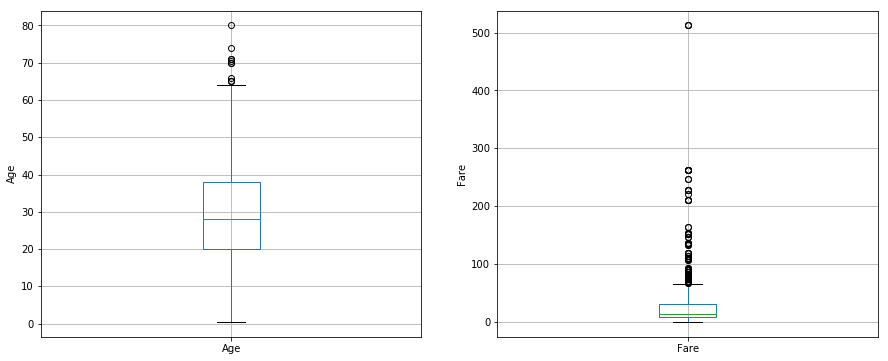

In [13]:
# let's make boxplots to visualise outliers in the continuous variables 
# Age and Fare

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = data.boxplot(column='Age')
fig.set_title('')
fig.set_ylabel('Age')

plt.subplot(1, 2, 2)
fig = data.boxplot(column='Fare')
fig.set_title('')
fig.set_ylabel('Fare')

Both Age and Fare contain outliers. Let's find which valuers are the outliers

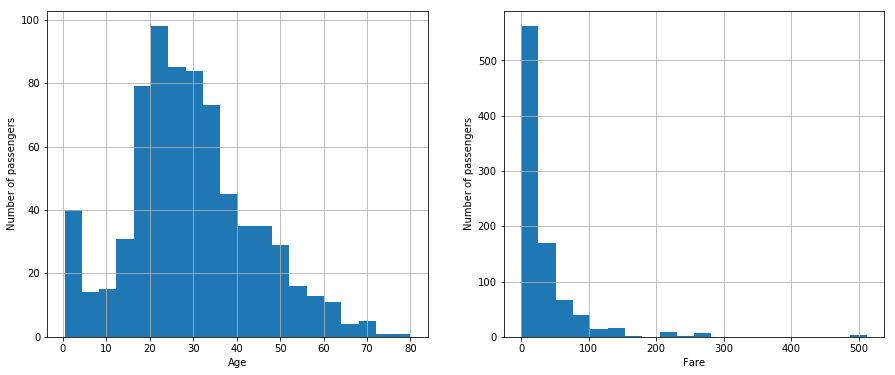

In [14]:
# first we plot the distributions to find out if they are Gaussian or skewed.
# Depending on the distribution, we will use the normal assumption or the interquantile
# range to find outliers

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = data.Age.hist(bins=20)
fig.set_ylabel('Number of passengers')
fig.set_xlabel('Age')

plt.subplot(1, 2, 2)
fig = data.Fare.hist(bins=20)
fig.set_ylabel('Number of passengers')
fig.set_xlabel('Fare')

Age is quite Gaussian and Fare is skewed, so I will use the Gaussian assumption for Age, and the interquantile range for Fare

In [15]:
# find outliers

# Age
Upper_boundary = data.Age.mean() + 3* data.Age.std()
Lower_boundary = data.Age.mean() - 3* data.Age.std()
print('Age outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_boundary, upperboundary=Upper_boundary))

# Fare
IQR = data.Fare.quantile(0.75) - data.Fare.quantile(0.25)
Lower_fence = data.Fare.quantile(0.25) - (IQR * 3)
Upper_fence = data.Fare.quantile(0.75) + (IQR * 3)
print('Fare outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))


Age outliers are values < -13.88037434994331 or > 73.27860964406095
Fare outliers are values < -61.358399999999996 or > 100.2688


We  should remove from the dataset Ages > 73 or Fares > 100.

There are a few methods to handle outliers, one is top-coding, the other one is discretisation of variables. **I will use top-coding for Age, and discretisation for Fare**.

#### Outlies in discrete variables

Let's calculate the percentage of passengers for each  of the values that can take the discrete variables in the titanic dataset. I will call outliers, those values that are present in less than 1% of the passengers. This is exactly the same as finding rare labels in categorical variables. Discrete variables, in essence can be pre-processed / engineered as if they were categorical. Keep this in mind.

In [16]:
# outlies in discrete variables
for var in ['Pclass',  'SibSp', 'Parch']:
    print(data[var].value_counts() / np.float(len(data)))
    print()

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

0    0.682379
1    0.234568
2    0.031425
4    0.020202
3    0.017957
8    0.007856
5    0.005612
Name: SibSp, dtype: float64

0    0.760943
1    0.132435
2    0.089787
5    0.005612
3    0.005612
4    0.004489
6    0.001122
Name: Parch, dtype: float64



**Pclass** does not contain outliers, as all its numbers are present in at least 20% of the passengers.

**SibSp**
This variable indicates the number of of siblings / spouses aboard the Titanic. Values bigger than 4, are rare. So I will cap this variable at 4 (top coding).

**Parch** 
This variable indicates the number of parents / children aboard the Titanic. We can see that values > 2 are rare (present in less than 1% of passengers). Thus I will cap this variable at 2 (top-coding).


#### Number of labels: cardinality

In [17]:
for var in categorical:
    print(var, ' contains ', len(data[var].unique()), ' labels')

Name  contains  891  labels
Sex  contains  2  labels
Ticket  contains  681  labels
Cabin  contains  148  labels
Embarked  contains  4  labels


The variables Name, Ticket and Cabin are highly cardinal, i.e., they contain a lot of labels. In addition, those variables are not usable as such, and they require some manual preprocessing. I will do that before proceeding with the data exploration

### Pre-processing of mixed type of variables (section 11)

The variables Cabin and Ticket contain both numbers and letters. Let's create 2 variables for each extracting the numerical and categorical part.

In [18]:
# Cabin
data['Cabin_numerical'] = data.Cabin.str.extract('(\d+)') # extracts number from string
data['Cabin_numerical'] = data['Cabin_numerical'].astype('float') # parses the above variable to float type

data['Cabin_categorical'] = data['Cabin'].str[0] # captures first letter of string (the letter of the cabin)

# same for submission data
submission['Cabin_numerical'] = submission.Cabin.str.extract('(\d+)')
submission['Cabin_numerical'] = submission['Cabin_numerical'].astype('float')

submission['Cabin_categorical'] = submission['Cabin'].str[0]

data[['Cabin', 'Cabin_numerical', 'Cabin_categorical']].head()

,Cabin,Cabin_numerical,Cabin_categorical
0,NaN,NaN,NaN
1,C85,85.0,C
2,NaN,NaN,NaN
3,C123,123.0,C
4,NaN,NaN,NaN


In [19]:
# drop the original variable
data.drop(labels='Cabin', inplace=True, axis=1)
submission.drop(labels='Cabin', inplace=True, axis=1)

In [20]:
#  Ticket
# extract the last bit of ticket as number
data['Ticket_numerical'] = data.Ticket.apply(lambda s: s.split()[-1])
data['Ticket_numerical'] = np.where(data.Ticket_numerical.str.isdigit(), data.Ticket_numerical, np.nan)
data['Ticket_numerical'] = data['Ticket_numerical'].astype('float')

# extract the first part of ticket as category
data['Ticket_categorical'] = data.Ticket.apply(lambda s: s.split()[0])
data['Ticket_categorical'] = np.where(data.Ticket_categorical.str.isdigit(), np.nan, data.Ticket_categorical)

# submission
submission['Ticket_numerical'] = submission.Ticket.apply(lambda s: s.split()[-1])
submission['Ticket_numerical'] = np.where(submission.Ticket_numerical.str.isdigit(), submission.Ticket_numerical, np.nan)
submission['Ticket_numerical'] = submission['Ticket_numerical'].astype('float')

# extract the first part of ticket as category
submission['Ticket_categorical'] = submission.Ticket.apply(lambda s: s.split()[0])
submission['Ticket_categorical'] = np.where(submission.Ticket_categorical.str.isdigit(), np.nan, submission.Ticket_categorical)

data[['Ticket', 'Ticket_numerical', 'Ticket_categorical']].head()

,Ticket,Ticket_numerical,Ticket_categorical
0,A/5 21171,21171.0,A/5
1,PC 17599,17599.0,PC
2,STON/O2. 3101282,3101282.0,STON/O2.
3,113803,113803.0,NaN
4,373450,373450.0,NaN


In [21]:
# let's explore the ticket categorical part a bit further
data.Ticket_categorical.unique()

array(['A/5', 'PC', 'STON/O2.', nan, 'PP', 'A/5.', 'C.A.', 'A./5.',
       'SC/Paris', 'S.C./A.4.', 'A/4.', 'CA', 'S.P.', 'S.O.C.', 'SO/C',
       'W./C.', 'SOTON/OQ', 'W.E.P.', 'STON/O', 'A4.', 'C', 'SOTON/O.Q.',
       'SC/PARIS', 'S.O.P.', 'A.5.', 'Fa', 'CA.', 'LINE', 'F.C.C.', 'W/C',
       'SW/PP', 'SCO/W', 'P/PP', 'SC', 'SC/AH', 'A/S', 'A/4', 'WE/P',
       'S.W./PP', 'S.O./P.P.', 'F.C.', 'SOTON/O2', 'S.C./PARIS',
       'C.A./SOTON'], dtype=object)

In [22]:
# it contains several labels, some of them seem very similar apart from the punctuation
# I will try to reduce this number of labels a bit further

# remove non letter characters from string
text = data.Ticket_categorical.apply(lambda x: re.sub("[^a-zA-Z]", '', str(x)))

# to visualise the output and compare with input
pd.concat([text, data.Ticket_categorical], axis=1)

,Ticket_categorical,Ticket_categorical
0,A,A/5
1,PC,PC
2,STONO,STON/O2.
3,nan,NaN
4,nan,NaN
5,nan,NaN
6,nan,NaN
7,nan,NaN
8,nan,NaN
9,nan,NaN


In [23]:
# set to upper case: we reduce the number of labels quite a bit
text = text.str.upper()
text.unique()

array(['A', 'PC', 'STONO', 'NAN', 'PP', 'CA', 'SCPARIS', 'SCA', 'SP',
       'SOC', 'WC', 'SOTONOQ', 'WEP', 'C', 'SOP', 'FA', 'LINE', 'FCC',
       'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH', 'AS', 'SOPP', 'FC', 'SOTONO',
       'CASOTON'], dtype=object)

In [24]:
# process the variable in submission as well
data['Ticket_categorical'] = text

submission['Ticket_categorical'] = submission.Ticket_categorical.apply(lambda x: re.sub("[^a-zA-Z]", '', str(x)))
submission['Ticket_categorical'] = submission['Ticket_categorical'].str.upper()

In [25]:
# drop the original variable
data.drop(labels='Ticket', inplace=True, axis=1)
submission.drop(labels='Ticket', inplace=True, axis=1)

### Bonus: tailored preprocessing for the Titanic dataset

The variable Name contains 891 different values, one for each of the passengers. We wouldn't be able to use this variable as is. However, we can extract some data from it, for example the title. See below.

In [26]:
def get_title(passenger):
    # extracts the title from the name variable
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['Title'] = data['Name'].apply(get_title)
submission['Title'] = submission['Name'].apply(get_title)

data[['Name', 'Title']].head()

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


In [27]:
# drop the original variable
data.drop(labels='Name', inplace=True, axis=1)
submission.drop(labels='Name', inplace=True, axis=1)

1     0.602694
2     0.180696
3     0.114478
4     0.032548
6     0.024691
5     0.016835
7     0.013468
11    0.007856
8     0.006734
Name: Family_size, dtype: float64


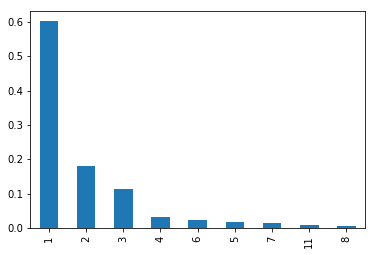

In [28]:
# create a variable indicating family size (including the passenger)
# sums siblings and parents

data['Family_size'] = data['SibSp']+data['Parch']+1
submission['Family_size'] = submission['SibSp']+submission['Parch']+1

print(data.Family_size.value_counts()/ np.float(len(data)))

(data.Family_size.value_counts() / np.float(len(data))).plot.bar()

The new variable Family size is discrete, because it is the sum of 2 discrete variables. It takes a finite number of values, and large families were rare on the Titanic. In fact, families larger than 7 people were rare, so I will **cap family size at 7**.

In [29]:
# variable indicating if passenger was a mother
data['is_mother'] = np.where((data.Sex =='female')&(data.Parch>=1)&(data.Age>18),1,0)
submission['is_mother'] = np.where((submission.Sex =='female')&(submission.Parch>=1)&(submission.Age>18),1,0)

data[['Sex', 'Parch', 'Age', 'is_mother']].head()

,Sex,Parch,Age,is_mother
0,male,0,22.0,0
1,female,0,38.0,0
2,female,0,26.0,0
3,female,0,35.0,0
4,male,0,35.0,0


In [30]:
data.loc[data.is_mother==1, ['Sex', 'Parch', 'Age', 'is_mother']].head()

,Sex,Parch,Age,is_mother
8,female,2,27.0,1
25,female,5,38.0,1
88,female,2,23.0,1
98,female,1,34.0,1
136,female,2,19.0,1


In [31]:
print('there were {} mothers in the Titanic'.format(data.is_mother.sum()))

there were 64 mothers in the Titanic


### Types of problems within variables II (section 3)

Let's look for missing data, outliers, cardinality and rare labels in the newly created variables.

#### New numerical variables: Missing values

In [32]:
data[['Cabin_numerical', 'Ticket_numerical', 'is_mother', 'Family_size']].isnull().mean()

Cabin_numerical     0.775533
Ticket_numerical    0.004489
is_mother           0.000000
Family_size         0.000000
dtype: float64

Cabin_numerical, as expected contains the same amount of missing data than the original variable Cabin. 

Ticket, also contains a small percentage of missing values. The other newly created variables do not contain missing data, as expected.

#### New numerical variables: Outliers

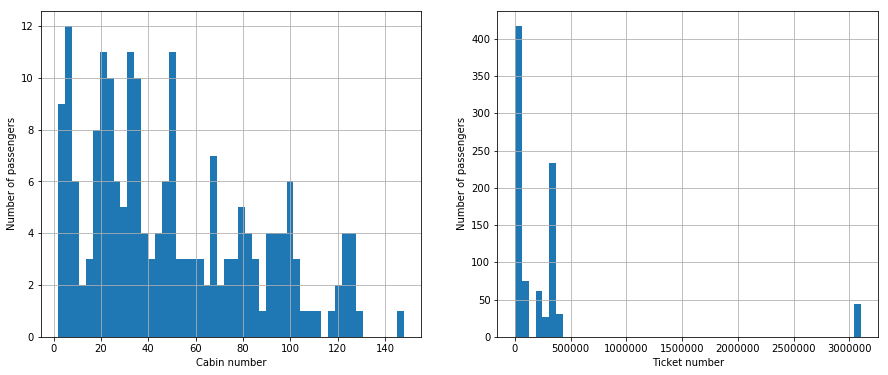

In [33]:
# first we plot the distributions to find out if they are Gaussian or skewed.
# Depending on the distribution, we will use the normal assumption or the interquantile
# range to find outliers

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = data.Cabin_numerical.hist(bins=50)
fig.set_ylabel('Number of passengers')
fig.set_xlabel('Cabin number')

plt.subplot(1, 2, 2)
fig = data.Ticket_numerical.hist(bins=50)
fig.set_ylabel('Number of passengers')
fig.set_xlabel('Ticket number')

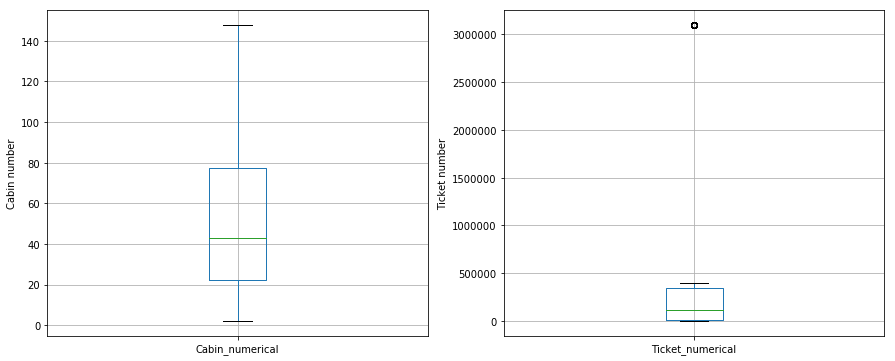

In [34]:
# let's visualise outliers with the boxplot and whiskers
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = data.boxplot(column='Cabin_numerical')
fig.set_title('')
fig.set_ylabel('Cabin number')

plt.subplot(1, 2, 2)
fig = data.boxplot(column='Ticket_numerical')
fig.set_title('')
fig.set_ylabel('Ticket number')

Cabin_numerical does not contain outliers. Ticket_numerical seems to contain a few outliers. Let's find out more about it.

In [35]:
# Ticket numerical
IQR = data.Ticket_numerical.quantile(0.75) - data.Ticket_numerical.quantile(
    0.25)
Lower_fence = data.Ticket_numerical.quantile(0.25) - (IQR * 3)
Upper_fence = data.Ticket_numerical.quantile(0.75) + (IQR * 3)
print(
    'Ticket number outliers are values < {lowerboundary} or > {upperboundary}'.
    format(lowerboundary=Lower_fence, upperboundary=Upper_fence))
passengers = len(data[data.Ticket_numerical > Upper_fence]) / np.float(
    len(data))
print('Number of passengers with ticket values higher than {upperboundary}: {passengers}'.format(upperboundary=Upper_fence, \
                                                                                                 passengers=passengers))

Ticket number outliers are values < -981730.0 or > 1343691.0
Number of passengers with ticket values higher than 1343691.0: 0.04938271604938271


I will use equal width discretisation for this variable.

#### New categorical variables: Missing values

In [36]:
data[['Cabin_categorical', 'Ticket_categorical', 'Title']].isnull().mean()

Cabin_categorical     0.771044
Ticket_categorical    0.000000
Title                 0.000000
dtype: float64

As expected, Cabin contains the same amount of missing data as the original Cabin variable.

The other 2 variables do not show missing data.

#### New categorical variables: cardinality

In [37]:
for var in ['Cabin_categorical', 'Ticket_categorical', 'Title']:
    print(var, ' contains ', len(data[var].unique()), ' labels')

Cabin_categorical  contains  9  labels
Ticket_categorical  contains  28  labels
Title  contains  5  labels


Title and Cabin are not highly cardinal, Ticket on the other hand has quite a few labels. Let's explore the percentage of passengers within each label to identify rare labels.

#### New categorical variables: rare labels

In [38]:
# rare / infrequent labels (less than 1% of passengers)
for var in ['Cabin_categorical', 'Ticket_categorical', 'Title']:
    print(data[var].value_counts() / np.float(len(data)))
    print()

C    0.066218
B    0.052750
D    0.037037
E    0.035915
A    0.016835
F    0.014590
G    0.004489
T    0.001122
Name: Cabin_categorical, dtype: float64

NAN        0.741863
PC         0.067340
CA         0.046016
A          0.031425
STONO      0.020202
SOTONOQ    0.016835
SCPARIS    0.012346
WC         0.011223
SOC        0.006734
C          0.005612
FCC        0.005612
LINE       0.004489
SCAH       0.003367
WEP        0.003367
SOPP       0.003367
PP         0.003367
PPP        0.002245
SWPP       0.002245
SOTONO     0.002245
SC         0.001122
AS         0.001122
CASOTON    0.001122
SCOW       0.001122
FA         0.001122
SCA        0.001122
SOP        0.001122
SP         0.001122
FC         0.001122
Name: Ticket_categorical, dtype: float64

Mr        0.581369
Miss      0.202020
Mrs       0.144781
Master    0.044893
Other     0.026936
Name: Title, dtype: float64



- Cabin contains the rare labels G and T: replace by most frequent category
- Ticket contains a lot of infrequent labels: replace by rare
- Title does not contain rare labels

Because the number of passengers in the rare cabins is so small, grouping them into a new category called rare, will be in itself rare, and may be prone to over-fitting. This, in cabin, I will replace rare labels by the most frequent category.

In ticket_categorical, on the other hand, the number of infrequent labels is high, therefore grouping them into a new label makes sense. 

### Separate train and test set

In [39]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data, data.Survived, test_size=0.2,
                                                    random_state=0)
X_train.shape, X_test.shape

((712, 16), (179, 16))

In [40]:
# let's group again the variables into categorical or numerical
# now considering the newly created variables

def find_categorical_and_numerical_variables(dataframe):
    cat_vars = [col for col in data.columns if data[col].dtypes == 'O']
    num_vars  = [col for col in data.columns if data[col].dtypes != 'O']
    return cat_vars, num_vars
                 
categorical, numerical = find_categorical_and_numerical_variables(data)       

In [41]:
categorical

['Sex', 'Embarked', 'Cabin_categorical', 'Ticket_categorical', 'Title']

In [42]:
numerical = [var for var in numerical if var not in ['Survived','PassengerId']]
numerical

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Cabin_numerical',
 'Ticket_numerical',
 'Family_size',
 'is_mother']

### Engineering missing values in numerical variables (section 5)

In [43]:
# print variables with missing data
for col in numerical:
    if X_train[col].isnull().mean()>0:
        print(col, X_train[col].isnull().mean())

Age 0.198033707865
Cabin_numerical 0.776685393258
Ticket_numerical 0.00561797752809


- Age and ticket contains < 50% NA: create additional variable with NA + random sample imputation
- Cabin_numerical contains > 50% NA: impute NA by value far in the distribution

In [44]:
def impute_na(X_train, df, variable):
    # make temporary df copy
    temp = df.copy()
    
    # extract random from train set to fill the na
    random_sample = X_train[variable].dropna().sample(temp[variable].isnull().sum(), random_state=0)
    
    # pandas needs to have the same index in order to merge datasets
    random_sample.index = temp[temp[variable].isnull()].index
    temp.loc[temp[variable].isnull(), variable] = random_sample
    return temp[variable]

In [45]:
# Age and ticket
# add variable indicating missingness
for df in [X_train, X_test, submission]:
    for var in ['Age', 'Ticket_numerical']:
        df[var+'_NA'] = np.where(df[var].isnull(), 1, 0)
    
# replace by random sampling
for df in [X_train, X_test, submission]:
    for var in ['Age', 'Ticket_numerical']:
        df[var] = impute_na(X_train, df, var)
    

# Cabin numerical
extreme = X_train.Cabin_numerical.mean() + X_train.Cabin_numerical.std()*3
for df in [X_train, X_test, submission]:
    df.Cabin_numerical.fillna(extreme, inplace=True)

### Engineering Missing Data in categorical variables (section 6)

In [46]:
# print variables with missing data
for col in categorical:
    if X_train[col].isnull().mean()>0:
        print(col, X_train[col].isnull().mean())

Embarked 0.00280898876404
Cabin_categorical 0.77106741573


- Embarked NA imputed by most frequent category, because NA is low
- Cabin_categorical imputed by 'Missing', because NA is high

In [47]:
# add label indicating 'Missing' to Cabin categorical
# or replace by most frequent label in Embarked

for df in [X_train, X_test, submission]:
    df['Embarked'].fillna(X_train['Embarked'].mode()[0], inplace=True)
    df['Cabin_categorical'].fillna('Missing', inplace=True)

In [48]:
# check absence of null values
X_train.isnull().sum()

PassengerId            0
Survived               0
Pclass                 0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Fare                   0
Embarked               0
Cabin_numerical        0
Cabin_categorical      0
Ticket_numerical       0
Ticket_categorical     0
Title                  0
Family_size            0
is_mother              0
Age_NA                 0
Ticket_numerical_NA    0
dtype: int64

In [49]:
X_test.isnull().sum()

PassengerId            0
Survived               0
Pclass                 0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Fare                   0
Embarked               0
Cabin_numerical        0
Cabin_categorical      0
Ticket_numerical       0
Ticket_categorical     0
Title                  0
Family_size            0
is_mother              0
Age_NA                 0
Ticket_numerical_NA    0
dtype: int64

In [50]:
submission.isnull().sum()

PassengerId            0
Pclass                 0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Fare                   1
Embarked               0
Cabin_numerical        0
Cabin_categorical      0
Ticket_numerical       0
Ticket_categorical     0
Title                  0
Family_size            0
is_mother              0
Age_NA                 0
Ticket_numerical_NA    0
dtype: int64

In [51]:
# Fare in the submission dataset contains one null value, I will replace it by the median 
submission.Fare.fillna(X_train.Fare.median(), inplace=True)

### Outliers in Numerical variables (section 8 and 15)

As I was analysing the outliers at the beginning of the notebook, I was taking a note on the preprocessing that I thought would be more convenient for each one of them. The notes are summarised here:

- Age: top-coding (73)
- Fare: equal frequency binning
- Sibsp: top-coding (4)
- Parch: top-coding (2)
- Family Size: top-coding (7)
- Ticket_number: equal frequency binning

In [52]:
def top_code(df, variable, top):
    return np.where(df[variable]>top, top, df[variable])

for df in [X_train, X_test, submission]:
    df['Age'] = top_code(df, 'Age', 73)
    df['SibSp'] = top_code(df, 'SibSp', 4)
    df['Parch'] = top_code(df, 'Parch', 2)
    df['Family_size'] = top_code(df, 'Family_size', 7)

In [53]:
# let's check that it worked
for var in ['Age',  'SibSp', 'Parch', 'Family_size']:
    print(var, ' max value: ', X_train[var].max())

Age  max value:  73.0
SibSp  max value:  4
Parch  max value:  2
Family_size  max value:  7


In [54]:
# let's check that it worked
for var in ['Age',  'SibSp', 'Parch', 'Family_size']:
    print(var, ' max value: ', submission[var].max())

Age  max value:  73.0
SibSp  max value:  4
Parch  max value:  2
Family_size  max value:  7


In [55]:
# find quantiles and discretise train set
X_train['Fare'], bins = pd.qcut(x=X_train['Fare'], q=8, retbins=True, precision=3, duplicates='raise')
X_test['Fare'] = pd.cut(x = X_test['Fare'], bins=bins, include_lowest=True)
submission['Fare'] = pd.cut(x = submission['Fare'], bins=bins, include_lowest=True)

In [56]:
submission.Fare.isnull().sum()

0

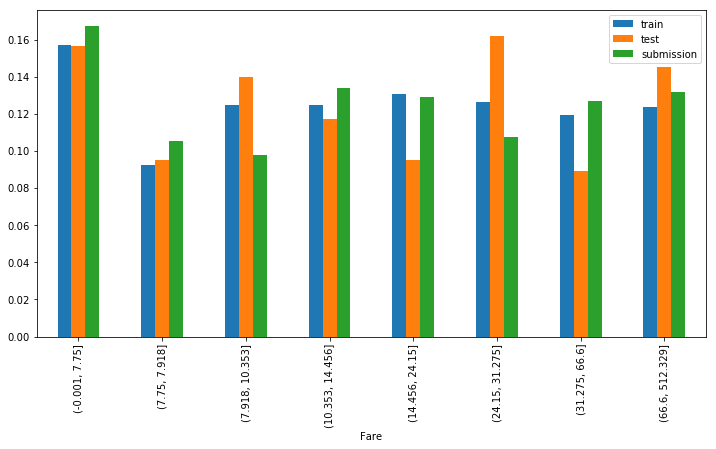

In [57]:
t1 = X_train.groupby(['Fare'])['Fare'].count() / np.float(len(X_train))
t2 = X_test.groupby(['Fare'])['Fare'].count() / np.float(len(X_test))
t3 = submission.groupby(['Fare'])['Fare'].count() / np.float(len(submission))

temp = pd.concat([t1,t2,t3], axis=1)
temp.columns = ['train', 'test', 'submission']
temp.plot.bar(figsize=(12,6))

In [58]:
# find quantiles and discretise train set
X_train['Ticket_numerical'], bins = pd.qcut(x=X_train['Ticket_numerical'], q=8, retbins=True, precision=3, duplicates='raise')
X_test['Ticket_numerical'] = pd.cut(x = X_test['Ticket_numerical'], bins=bins, include_lowest=True)
submission['Ticket_numerical_temp'] = pd.cut(x = submission['Ticket_numerical'], bins=bins, include_lowest=True)

In [59]:
X_test.Ticket_numerical.isnull().sum()

0

In [60]:
submission.Ticket_numerical_temp.isnull().sum()

2

In [61]:
submission[submission.Ticket_numerical_temp.isnull()][['Ticket_numerical', 'Ticket_numerical_temp']]

,Ticket_numerical,Ticket_numerical_temp
186,2.0,NaN
302,2.0,NaN


There are 2 values of ticket in the submission dataset, that could not be placed within the intervals calculated for the training set. let's look at the intervals to understand why this could have been the case.

In [62]:
# inspect the ticket bins in training set
X_train.Ticket_numerical.unique()

[(2.999, 2816.875], (14737.5, 24421.875], (364848.0, 3101317.0], (24421.875, 113053.0], (248701.0, 347077.25], (113053.0, 248701.0], (2816.875, 14737.5], (347077.25, 364848.0]]
Categories (8, interval[float64]): [(2.999, 2816.875] < (2816.875, 14737.5] < (14737.5, 24421.875] < (24421.875, 113053.0] < (113053.0, 248701.0] < (248701.0, 347077.25] < (347077.25, 364848.0] < (364848.0, 3101317.0]]

The lowest bin starts at 2.99, and the values for the tickets in the submission are 2, so slight below the interval. I will bottom code then that variable, and include those 2 values within the lowest interval. See below.

In [63]:
X_train.Ticket_numerical.unique()[0]

Interval(2.9990000000000001, 2816.875, closed='right')

There are 2 Ticket numerical parts in the submission dataset that are lower than any other in the training set. This I will include those in the lowest interval [2.99-2816]

In [64]:
submission.loc[submission.Ticket_numerical_temp.isnull(), 'Ticket_numerical_temp'] = X_train.Ticket_numerical.unique()[0]
submission.Ticket_numerical_temp.isnull().sum()

0

In [65]:
submission['Ticket_numerical'] = submission['Ticket_numerical_temp']
submission.drop(labels=['Ticket_numerical_temp'], inplace=True, axis=1)
submission.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_numerical,Cabin_categorical,Ticket_numerical,Ticket_categorical,Title,Family_size,is_mother,Age_NA,Ticket_numerical_NA
0,892,3,male,34.5,0,0,"(7.75, 7.918]",Q,158.222059,Missing,"(248701.0, 347077.25]",NAN,Mr,1,0,0,0
1,893,3,female,47.0,1,0,"(-0.001, 7.75]",S,158.222059,Missing,"(347077.25, 364848.0]",NAN,Mrs,2,0,0,0
2,894,2,male,62.0,0,0,"(7.918, 10.353]",Q,158.222059,Missing,"(113053.0, 248701.0]",NAN,Mr,1,0,0,0
3,895,3,male,27.0,0,0,"(7.918, 10.353]",S,158.222059,Missing,"(248701.0, 347077.25]",NAN,Mr,1,0,0,0
4,896,3,female,22.0,1,1,"(10.353, 14.456]",S,158.222059,Missing,"(364848.0, 3101317.0]",NAN,Mrs,3,1,0,0


### Engineering rare labels in categorical variables (section 9)

In [66]:
# find unfrequent labels in categorical variables
for var in categorical:
    print(var, X_train[var].value_counts()/np.float(len(X_train)))
    print()

Sex male      0.65309
female    0.34691
Name: Sex, dtype: float64

Embarked S    0.728933
C    0.181180
Q    0.089888
Name: Embarked, dtype: float64

Cabin_categorical Missing    0.771067
C          0.061798
B          0.050562
E          0.040730
D          0.036517
A          0.021067
F          0.012640
G          0.004213
T          0.001404
Name: Cabin_categorical, dtype: float64

Ticket_categorical NAN        0.728933
PC         0.066011
CA         0.050562
A          0.035112
STONO      0.023876
SOTONOQ    0.016854
SCPARIS    0.014045
WC         0.014045
SOC        0.007022
C          0.005618
LINE       0.005618
PP         0.004213
WEP        0.004213
PPP        0.002809
SOPP       0.002809
FCC        0.002809
SCAH       0.002809
SOTONO     0.002809
AS         0.001404
SCOW       0.001404
FA         0.001404
FC         0.001404
SCA        0.001404
SP         0.001404
SWPP       0.001404
Name: Ticket_categorical, dtype: float64

Title Mr        0.589888
Miss      0.200843
Mrs   

- Cabin contains the rare labels G and T: replace by most frequent category
- Ticket contains a lot of infrequent labels: replace by rare

Because the number of passengers in the rare cabins is so small, grouping them into a new category called rare, will be in itself rare, and may be prone to over-fitting. Thus, in cabin, I will replace rare labels by the most frequent category.
In ticket_categorical, on the other hand, the number of infrequent labels is high, therefore grouping them into a new label makes sense.

In [67]:
def rare_imputation(variable, which='rare'):    
    # find frequent labels
    temp = X_train.groupby([variable])[variable].count()/np.float(len(X_train))
    frequent_cat = [x for x in temp.loc[temp>0.01].index.values]
    
    # create new variables, with Rare labels imputed
    if which=='frequent':
        # find the most frequent category
        mode_label = X_train.groupby(variable)[variable].count().sort_values().tail(1).index.values[0]
        X_train[variable] = np.where(X_train[variable].isin(frequent_cat), X_train[variable], mode_label)
        X_test[variable] = np.where(X_test[variable].isin(frequent_cat), X_test[variable], mode_label)
        submission[variable] = np.where(submission[variable].isin(frequent_cat), submission[variable], mode_label)
    
    else:
        X_train[variable] = np.where(X_train[variable].isin(frequent_cat), X_train[variable], 'Rare')
        X_test[variable] = np.where(X_test[variable].isin(frequent_cat), X_test[variable], 'Rare')
        submission[variable] = np.where(submission[variable].isin(frequent_cat), submission[variable], 'Rare')

In [68]:
rare_imputation('Cabin_categorical', 'frequent')
rare_imputation('Ticket_categorical', 'rare')

In [69]:
# let's check that it worked
for var in categorical:
    print(var, X_train[var].value_counts()/np.float(len(X_train)))
    print()

Sex male      0.65309
female    0.34691
Name: Sex, dtype: float64

Embarked S    0.728933
C    0.181180
Q    0.089888
Name: Embarked, dtype: float64

Cabin_categorical Missing    0.776685
C          0.061798
B          0.050562
E          0.040730
D          0.036517
A          0.021067
F          0.012640
Name: Cabin_categorical, dtype: float64

Ticket_categorical NAN        0.728933
PC         0.066011
Rare       0.050562
CA         0.050562
A          0.035112
STONO      0.023876
SOTONOQ    0.016854
WC         0.014045
SCPARIS    0.014045
Name: Ticket_categorical, dtype: float64

Title Mr        0.589888
Miss      0.200843
Mrs       0.140449
Master    0.049157
Other     0.019663
Name: Title, dtype: float64



In [70]:
# let's check that it worked
for var in categorical:
    print(var, submission[var].value_counts()/np.float(len(submission)))
    print()

Sex male      0.636364
female    0.363636
Name: Sex, dtype: float64

Embarked S    0.645933
C    0.244019
Q    0.110048
Name: Embarked, dtype: float64

Cabin_categorical Missing    0.784689
C          0.083732
B          0.043062
D          0.031100
E          0.021531
F          0.019139
A          0.016746
Name: Cabin_categorical, dtype: float64

Ticket_categorical NAN        0.708134
PC         0.076555
Rare       0.064593
CA         0.064593
A          0.026316
SOTONOQ    0.021531
SCPARIS    0.019139
WC         0.011962
STONO      0.007177
Name: Ticket_categorical, dtype: float64

Title Mr        0.574163
Miss      0.186603
Mrs       0.172249
Master    0.050239
Other     0.016746
Name: Title, dtype: float64



### Encode categorical variables (section 10)

In [71]:
categorical

['Sex', 'Embarked', 'Cabin_categorical', 'Ticket_categorical', 'Title']

- Sex: one hot encoding
- Remaining variables: replace by risk probability

In [72]:
for df in [X_train, X_test, submission]:
    df['Sex']  = pd.get_dummies(df.Sex, drop_first=True)

In [73]:
X_train.Sex.unique()

array([0, 1], dtype=uint64)

In [74]:
X_test.Sex.unique()

array([1, 0], dtype=uint64)

In [75]:
submission.Sex.unique()

array([1, 0], dtype=uint64)

In [76]:
def encode_categorical_variables(var, target):
        # make label to risk dictionary
        ordered_labels = X_train.groupby([var])[target].mean().to_dict()
        
        # encode variables
        X_train[var] = X_train[var].map(ordered_labels)
        X_test[var] = X_test[var].map(ordered_labels)
        submission[var] = submission[var].map(ordered_labels)

# enccode labels in categorical vars
for var in categorical:
    encode_categorical_variables(var, 'Survived')

In [77]:
# parse discretised variables to object before encoding
for df in [X_train, X_test, submission]:
    df.Fare = df.Fare.astype('O')
    df.Ticket_numerical = df.Ticket_numerical.astype('O')

In [78]:
# encode labels
for var in ['Fare', 'Ticket_numerical']:
    print(var)
    encode_categorical_variables(var, 'Survived')

Fare
Ticket_numerical


In [79]:
#let's inspect the dataset
X_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_numerical,Cabin_categorical,Ticket_numerical,Ticket_categorical,Title,Family_size,is_mother,Age_NA,Ticket_numerical_NA
140,141,0,3,0.744939,27.0,0,2,0.397849,0.527132,158.222059,0.307414,0.348315,0.394990,0.790000,3,0,1,0
439,440,0,2,0.191398,31.0,0,0,0.404494,0.342967,158.222059,0.307414,0.573034,0.305556,0.157143,1,0,0,0
817,818,0,2,0.191398,31.0,1,1,0.494118,0.527132,158.222059,0.307414,0.348315,0.500000,0.157143,3,0,0,0
378,379,0,3,0.191398,20.0,0,0,0.223214,0.527132,158.222059,0.307414,0.348315,0.394990,0.157143,1,0,0,0
491,492,0,3,0.191398,21.0,0,0,0.223214,0.342967,158.222059,0.307414,0.306818,0.166667,0.157143,1,0,0,0


We can see that the labels how now been replaced by the survival probability.

### Feature scaling (section 13)

In [80]:
X_train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_numerical,Cabin_categorical,Ticket_numerical,Ticket_categorical,Title,Family_size,is_mother,Age_NA,Ticket_numerical_NA
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,443.283708,0.383427,2.317416,0.383427,29.807584,0.484551,0.353933,0.383427,0.383427,133.956178,0.383427,0.383427,0.383427,0.383427,1.875000,0.067416,0.198034,0.005618
std,260.003783,0.486563,0.833767,0.263664,14.496489,0.907718,0.673811,0.144616,0.071238,48.398112,0.149408,0.118238,0.098434,0.276532,1.460148,0.250917,0.398798,0.074795
min,1.000000,0.000000,1.000000,0.191398,0.670000,0.000000,0.000000,0.212121,0.342967,2.000000,0.307414,0.166667,0.080000,0.157143,1.000000,0.000000,0.000000,0.000000
25%,211.750000,0.000000,2.000000,0.191398,21.000000,0.000000,0.000000,0.232770,0.342967,158.222059,0.307414,0.321087,0.394990,0.157143,1.000000,0.000000,0.000000,0.000000
50%,441.000000,0.000000,3.000000,0.191398,28.750000,0.000000,0.000000,0.397849,0.342967,158.222059,0.307414,0.370787,0.394990,0.157143,1.000000,0.000000,0.000000,0.000000
75%,671.250000,1.000000,3.000000,0.744939,38.000000,1.000000,0.000000,0.444444,0.421875,158.222059,0.307414,0.474719,0.394990,0.706294,2.000000,0.000000,0.000000,0.000000
max,890.000000,1.000000,3.000000,0.744939,73.000000,4.000000,2.000000,0.659091,0.527132,158.222059,0.758621,0.573034,0.617021,0.790000,7.000000,1.000000,1.000000,1.000000


In [81]:
variables_that_need_scaling = ['Pclass', 'Age', 'Sibsp', 'Parch', 'Cabin_numerical', 'Family_size']

In [82]:
training_vars = [var for var in X_train.columns if var not in ['PassengerId', 'Survived']]
training_vars

['Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked',
 'Cabin_numerical',
 'Cabin_categorical',
 'Ticket_numerical',
 'Ticket_categorical',
 'Title',
 'Family_size',
 'is_mother',
 'Age_NA',
 'Ticket_numerical_NA']

In [83]:
# fit scaler
scaler = MinMaxScaler() # create an instance
scaler.fit(X_train[training_vars]) #  fit  the scaler to the train set and then transform it

MinMaxScaler(copy=True, feature_range=(0, 1))

The scaler is now ready, we can use it in a machine learning algorithm when required. See below.

### Machine Learning algorithm building

#### xgboost

In [84]:
xgb_model = xgb.XGBClassifier()

eval_set = [(X_test[training_vars], y_test)]
xgb_model.fit(X_train[training_vars], y_train, eval_metric="auc", eval_set=eval_set, verbose=False)

pred = xgb_model.predict_proba(X_train[training_vars])
print('xgb train roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
pred = xgb_model.predict_proba(X_test[training_vars])
print('xgb test roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

xgb train roc-auc: 0.9388929218086394
xgb test roc-auc: 0.9077733860342556


#### Random Forests

In [85]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train[training_vars], y_train)

pred = rf_model.predict_proba(X_train[training_vars])
print('RF train roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
pred = rf_model.predict_proba(X_test[training_vars])
print('RF test roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

RF train roc-auc: 0.9982310779577295
RF test roc-auc: 0.8945981554677207


#### Adaboost

In [86]:
ada_model = AdaBoostClassifier()
ada_model.fit(X_train[training_vars], y_train)

pred = ada_model.predict_proba(X_train[training_vars])
print('Adaboost train roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
pred = ada_model.predict_proba(X_test[training_vars])
print('Adaboost test roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

Adaboost train roc-auc: 0.8973441137450249
Adaboost test roc-auc: 0.8706192358366273


#### Logistic regression

In [87]:
logit_model = LogisticRegression()
logit_model.fit(scaler.transform(X_train[training_vars]), y_train)

pred = logit_model.predict_proba(scaler.transform(X_train[training_vars]))
print('Logit train roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
pred = ada_model.predict_proba(scaler.transform(X_test[training_vars]))
print('Logit test roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

Logit train roc-auc: 0.8724915934483133
Logit test roc-auc: 0.8268774703557312


### Select threshold for maximum accuracy

In [88]:
pred_ls = []
for model in [xgb_model, rf_model, ada_model, logit_model]:
    pred_ls.append(pd.Series(model.predict_proba(X_test[training_vars])[:,1]))

final_pred = pd.concat(pred_ls, axis=1).mean(axis=1)
print('Ensemble test roc-auc: {}'.format(roc_auc_score(y_test,final_pred)))

Ensemble test roc-auc: 0.9106719367588931


In [89]:
tpr, tpr, thresholds = metrics.roc_curve(y_test, final_pred)
thresholds

array([ 0.62887334,  0.57844404,  0.57404189,  0.56136034,  0.5611278 ,
        0.52896941,  0.52819212,  0.51329908,  0.51176485,  0.46151215,
        0.42590368,  0.4157962 ,  0.40317914,  0.38411698,  0.37637827,
        0.3716263 ,  0.36255445,  0.35742418,  0.35366244,  0.34411429,
        0.33705063,  0.33621705,  0.32975272,  0.3228687 ,  0.32075407,
        0.32020933,  0.30779934,  0.30114494,  0.28647033,  0.27682098,
        0.25926278,  0.24921405,  0.23840703,  0.23403145,  0.22316067,
        0.22203072,  0.21961142,  0.21952678,  0.18889223,  0.1883331 ,
        0.18169372,  0.1797722 ,  0.17787358,  0.15210567,  0.15075582,
        0.14506151,  0.14492661,  0.14479344,  0.14448713,  0.14272373,
        0.14182324,  0.14054127,  0.13657478,  0.13573485,  0.1332098 ,
        0.13034344,  0.12988231])

In [90]:
accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(final_pred>thres,1,0)
    accuracy_ls.append(metrics.accuracy_score(y_test, y_pred, normalize=True))
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)],
                        axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head()

,thresholds,accuracy
9,0.461512,0.843575
15,0.371626,0.843575
14,0.376378,0.843575
13,0.384117,0.837989
20,0.337051,0.837989


### Submission to Kaggle

In [91]:
pred_ls = []
for model in [xgb_model, rf_model, ada_model, logit_model]:
    pred_ls.append(pd.Series(model.predict_proba(submission[training_vars])[:,1]))

final_pred = pd.concat(pred_ls, axis=1).mean(axis=1)

In [92]:
final_pred = pd.Series(np.where(final_pred>0.40,1,0))

In [93]:
temp = pd.concat([submission.PassengerId, final_pred], axis=1)
temp.columns = ['PassengerId', 'Survived']
temp.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [94]:
temp.to_csv('submit_titanic.csv', index=False)

### Feature importance

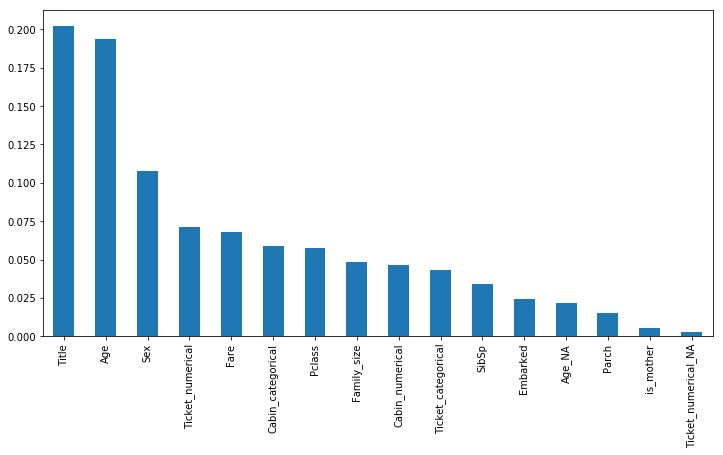

In [95]:
importance = pd.Series(rf_model.feature_importances_)
importance.index = training_vars
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))

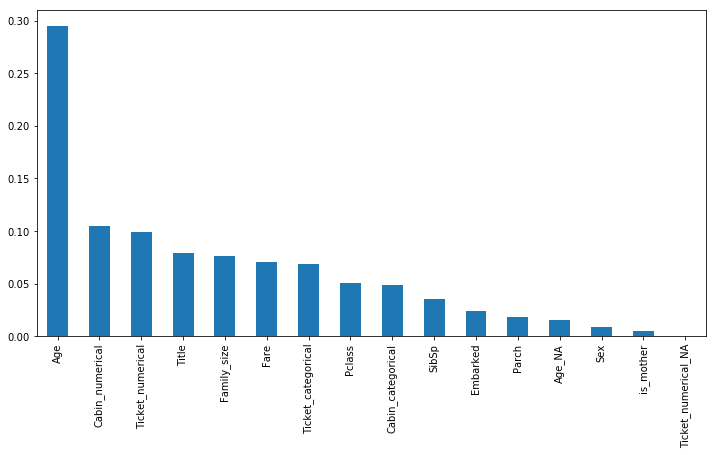

In [96]:
importance = pd.Series(xgb_model.feature_importances_)
importance.index = training_vars
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))

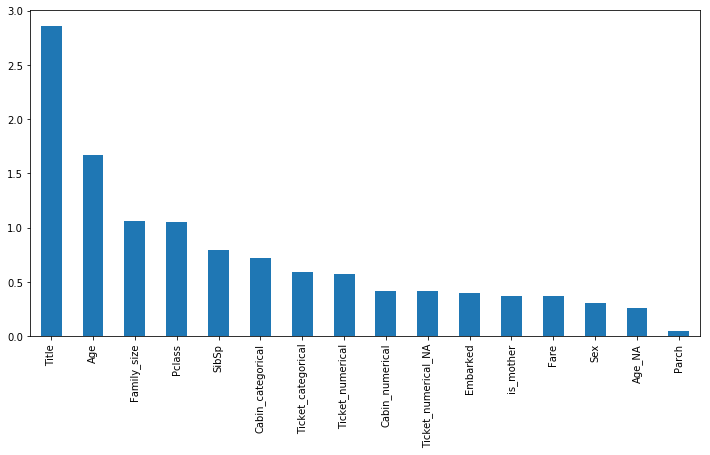

In [97]:
importance = pd.Series(np.abs(logit_model.coef_.ravel()))
importance.index = training_vars
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))